In [2]:
import torch
import torch.nn as nn 
from torch.linalg import inv

In [3]:
from torchvision import transforms, io
from torch import mean, stack, Size, std, cuda, zeros
from PIL import Image

In [4]:
class Tanh(nn.Module):
    def forward(self, inp):
        return torch.tanh(inp)

    def deriv(self, inp):
        return 1.0 - torch.tanh(inp) ** 2.0


class Linear(nn.Module):
    def forward(self, inp):
        return inp

    def deriv(self, inp):
        return torch.ones((1,)).to(inp.device)

This is an implementation of the temporal predictive coding model that is consistent with 

In [16]:
class FastTPC(nn.Module):
    def __init__(self, control_size, hidden_size, output_size, nonlin='tanh'):
        """A more concise and pytorchy way of implementing tPC

        Suitable for image sequences
        """
        super(FastTPC, self).__init__()
        self.hidden_size = hidden_size
        self.A = (nn.Linear(hidden_size, hidden_size, bias=False)).weight # A
        self.C = (nn.Linear(hidden_size, output_size, bias=False)).weight # C
        

        self.hidden_loss = None
        self.obs_loss = None

        self.err_x = None
        self.pred_y = None
        self.err_x = None 
        self.prev_x = None
        self.x = None
        self.delta_x = None
        self.delta_A = None
        self.delta_C = None 

        if nonlin == 'linear':
            self.f = Linear()
        elif nonlin == 'tanh':
            self.f = Tanh()
        else:
            raise ValueError("no such nonlinearity!")
        
    def forward(self):
        self.pred_x = self.A @ self.f(self.x)
        self.pred_y = self.C @ self.f(self.pred_x) 
        
    def init_hidden(self, bsz):
        """Initializing prev_z"""
        self.prev_x = nn.init.kaiming_uniform_(torch.empty(self.hidden_size, bsz))
    
    def update_errs(self, y):
        self.err_x = self.x - self.A @ self.f(self.prev_x) 
        self.err_y = y - self.C @ self.f(self.x) 
    
    def update_nodes(self, y, inf_lr):
        self.update_errs(y)
        self.delta_x = -self.err_x + (self.f.deriv(self.x).t() @ (self.C.t() @ self.err_y)) #  (10)
        self.x += inf_lr * self.delta_x

    def inference(self, inf_iters, inf_lr, y):
        """prev_z should be set up outside the inference, from the previous timestep
        After every time step, we change prev_z to self.z
        """
        self.x = self.prev_x.clone() 
        # update the values nodes
        for i in range(inf_iters):
            self.update_nodes(y, inf_lr)

    def update_transition(self, learn_lr1, y): # (11)
        with torch.no_grad():
            
            self.delta_A = self.err_x @ self.f(self.prev_x).t() # Because tensors are mutuable, prev_x and x are the same all the time. I guess not conceptually becaus x does change
            self.A += learn_lr1 * self.delta_A

    def update_emission(self, learn_lr2, y): # (11)
        with torch.no_grad():
            # I feel like this is needed for convergence but paper doesn't mention it 
            self.delta_C = self.err_y @ self.f(self.x).t() # not sure rn which of these is supposed to b transposed
            self.C += learn_lr2 * self.delta_C




Quick demonstration of the model for static images

In [17]:
model = FastTPC(151875,1000,151875) # Initialise the model

In [25]:
bar_img = Image.open("Cute_Dog.jpg") # load the input, convert it to a tensor, flatten the tensor to a vector
convert_tensor = transforms.ToTensor()
tensor_1 = convert_tensor(bar_img)
flat = tensor_1.view(151875,1)
transform = transforms.ToPILImage()

In [22]:
model.init_hidden(1) # initialise the hidden layer

In [20]:
for i in range(5):    # Calling inference 10 times, after every time assigning the current hidden state (model.z) to the previous hidden state (prev_z). In my head this means I'm showing it the same picture 10 times.
    model.inference(inf_iters=5, inf_lr=0.001, y=flat)
    model.update_transition(learn_lr1=0.001, y=flat)
    model.update_emission(learn_lr2=0.001, y=flat)
    model.prev_x = model.x.clone()


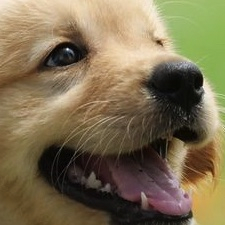

In [21]:
model.forward()
output_image = model.pred_y.view(3, 225, 225)
transform(output_image)